<a href="https://colab.research.google.com/github/Ankit-2000/Pruning-neural-network/blob/master/pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
model = tf.keras.models.Sequential([ \
  tf.keras.layers.Flatten(input_shape=(28, 28)), \
  tf.keras.layers.Dense(1000, activation=tf.nn.relu),\
  tf.keras.layers.Dense(1000, activation=tf.nn.relu),\
  tf.keras.layers.Dense(500, activation=tf.nn.relu),\
  tf.keras.layers.Dense(200, activation=tf.nn.relu),\
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)\
])
# text_model is just used for testing our pruning results, the reason for using a diff model is that in colab 
# I wanted to run a section of code again and again, leading to loosing the original weight matrix obtained
# so, .set_weights() is applied on test_model
test_model = tf.keras.models.Sequential([\
  tf.keras.layers.Flatten(input_shape=(28, 28)),\
  tf.keras.layers.Dense(1000, activation=tf.nn.relu),\
  tf.keras.layers.Dense(1000, activation=tf.nn.relu),\
  tf.keras.layers.Dense(500, activation=tf.nn.relu),\
  tf.keras.layers.Dense(200, activation=tf.nn.relu),\
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)\
])

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
test_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)
initial_acc = model.evaluate(x_test, y_test)[1]

Epoch 1/5
60000/60000 [==============================] - 17s 288us/sample - loss: 0.2134 - acc: 0.9369
Epoch 2/5
60000/60000 [==============================] - 17s 275us/sample - loss: 0.1036 - acc: 0.9708
Epoch 3/5
60000/60000 [==============================] - 16s 273us/sample - loss: 0.0789 - acc: 0.9777
Epoch 4/5
60000/60000 [==============================] - 16s 273us/sample - loss: 0.0620 - acc: 0.9827
Epoch 5/5
10000/10000 [==============================] - 1s 85us/sample - loss: 0.0939 - acc: 0.9766


In [0]:
WEIGHT_MATRIX = model.get_weights()
COMPLETE_MATRIX = {}
# COMPLETE_MATRIX is dict that contains the key as (indice of the WEIGHT_MATRIX, row, column of the weight) and value as the weight.
LAYER = 0
while LAYER < len(WEIGHT_MATRIX)-2:
  for rows in range(WEIGHT_MATRIX[LAYER].shape[0]):
      for columns in range(WEIGHT_MATRIX[LAYER].shape[1]):
          COMPLETE_MATRIX[(LAYER, rows, columns)] = WEIGHT_MATRIX[LAYER][rows][columns]
  LAYER += 2

'''
        sorted() sorts the dict as per the abs value of the values and is stored in the form of an array 
        sort will be of the form ((a,b,c), weight) in ascending order of weights
        where, 
        a ---> layer i.e. 1,2,3
        b ---> row 
        c ---> column

        weight ---> weight of the corresponding neuron

        sort can be accesssed in the following ways :
        
        Eg. if  a = [((3, 190, 156), 4.8154054), ((2, 190, 156), 4.8154054)]
        
        a[0] ---------> ((3, 190, 156), 4.8154054)

        a[0][1] ------> 4.8154054
        a[0][0] ------> (3, 190, 156)
        
        a[0][0][1] ---> 190
        a[0][0][2] ---> 156
        a[0][0][0] ---> 3
'''
# Sorting the dict
sort = sorted(COMPLETE_MATRIX.items(), key=lambda kv: abs(kv[1]))

10000/10000 [==============================] - 1s 86us/sample - loss: 2.4412 - acc: 0.0974


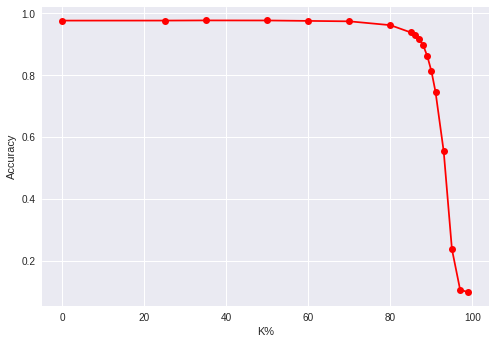

In [0]:
# more %k were added to get a better plot
k = [0, 25, 35, 50, 60, 70, 80, 85, 86, 87, 88, 89, 90, 91, 93, 95, 97, 99]
Accuracy_prunned = []
for values in k:
    i = 0
    total_weights = len(sort)
    weights_to_be_prunned = values*total_weights/100
    while i < int(weights_to_be_prunned):
      WEIGHT_MATRIX[sort[i][0][0]][sort[i][0][1], sort[i][0][2]] = 0
      i += 1
#   setting the wts for test_model    
    test_model.set_weights(WEIGHT_MATRIX)    
    Accuracy_prunned.append(test_model.evaluate(x_test, y_test)[1]) 

plt.plot(k, Accuracy_prunned, 'r', marker='o')
plt.xlabel('K%')
plt.ylabel('Accuracy')
plt.show()

In [0]:
WEIGHT_MATRIX = model.get_weights()
COMPLETE_MATRIX = {}
LAYER = 0

while LAYER < len(WEIGHT_MATRIX)-2:
  temp_row_vector = np.linalg.norm(WEIGHT_MATRIX[LAYER], axis=0)
  for columns in range(WEIGHT_MATRIX[LAYER].shape[1]):
     COMPLETE_MATRIX[(LAYER, columns)] = temp_row_vector[columns]
  LAYER += 2
sort = sorted(COMPLETE_MATRIX.items(), key=lambda kv: kv[1])

'''
        sort will be of the form ((a,b), c) in ascending order of weights where,
        a ---> layer i.e. 0,2,4,6,8
        b ---> column 
        c ---> L2-norm of the column vector
        
        sort can be accesssed in the following ways :
        
        Eg. if  a = [((3, 190), 4.8154054), ((2, 190), 4.8154054)]
        a[0] ---------> ((3, 190), 4.8154054)
        a[0][1] ------> 4.8154054
        a[0][0] ------> (3, 190)
'''


'\n        sort will be of the form ((a,b), c) in ascending order of weights where,\n        a ---> layer i.e. 0,2,4,6,8\n        b ---> column \n        c ---> L2-norm of the column vector\n        \n        sort can be accesssed in the following ways :\n        \n        Eg. if  a = [((3, 190), 4.8154054), ((2, 190), 4.8154054)]\n        a[0] ---------> ((3, 190), 4.8154054)\n        a[0][1] ------> 4.8154054\n        a[0][0] ------> (3, 190)\n'

10000/10000 [==============================] - 1s 86us/sample - loss: 2.4212 - acc: 0.0974


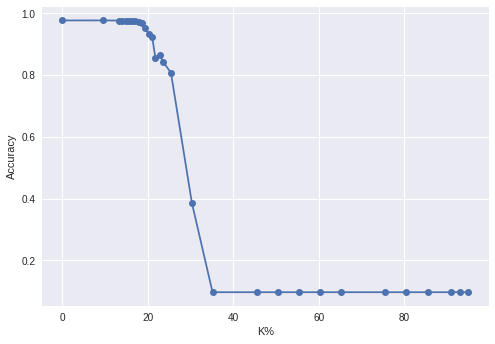

In [0]:
# more %k were added to get a better plot
WEIGHT_MATRIX = model.get_weights()
k_for_neurons = [0, 10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 35, 40, 50, 55, 60, 65, 70, 80, 85, 90, 95, 97, 99]
corresponding_wt= []
total = 784*1000 + 1000*1000 + 1000*500 + 500*200
Accuracy_neuron_prunning = []

for values in k_for_neurons:
    total_neurons = len(sort)
    neurons_to_be_prunned = values*total_neurons/100
    i = 0
    temp = 0
    while i < int(neurons_to_be_prunned):
      WEIGHT_MATRIX[sort[i][0][0]][:, sort[i][0][1]] = 0
      temp += WEIGHT_MATRIX[sort[i][0][0]].shape[1]
      i += 1
    corresponding_wt.append((temp)*100/total)
#   setting the wts for test_model    
    test_model.set_weights(WEIGHT_MATRIX)
    Accuracy_neuron_prunning.append(test_model.evaluate(x_test, y_test)[1])

      
plt.plot(corresponding_wt, Accuracy_neuron_prunning, marker='o')
plt.xlabel('K%')
plt.ylabel('Accuracy')
plt.show()

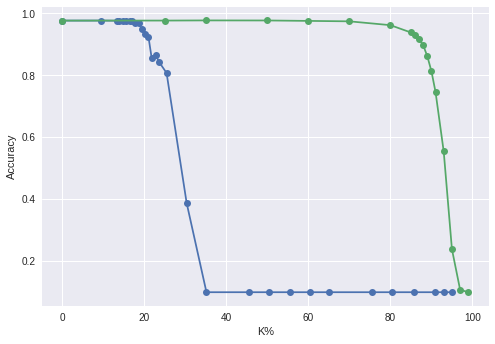

In [0]:
plt.plot(corresponding_wt, Accuracy_neuron_prunning, k, Accuracy_prunned, marker='o')
plt.xlabel('K%')
plt.ylabel('Accuracy')
plt.show()

In [0]:
'''
Code for additional graphs i.e histogram
'''
# COMPLETE = {}
# # COMPLETE_MATRIX is dict that contains the key as (indice of the WEIGHT_MATRIX, row, column of the weight) and value as the weight.
# LAYER = 0
# while LAYER < len(WEIGHT_MATRIX)-2:
#   for rows in range(WEIGHT_MATRIX[LAYER].shape[0]):
#       for columns in range(WEIGHT_MATRIX[LAYER].shape[1]):
#           COMPLETE[(LAYER, rows, columns)] = WEIGHT_MATRIX[LAYER][rows][columns]
#   LAYER += 2

# plt.hist(COMPLETE.values(), bins =60)
# plt.xlabel('Weights')
# plt.ylabel('Frequency')
# plt.title('weight distribution for 0% pruning')
# plt.show()

# k_for_neurons = 25

# total = 784*1000 + 1000*1000 + 1000*500 + 500*200
# total_neurons = len(sort)
# neurons_to_be_prunned = k_for_neurons*total_neurons/100
# i = 0
# while i < int(neurons_to_be_prunned):
#   rows = 0
#   while rows<WEIGHT_MATRIX[sort[i][0][0]].shape[0]:
#     COMPLETE.pop((sort[i][0][0],rows ,sort[i][0][1]))
#     rows += 1
#   i += 1

# #   setting the wts for test_model    
# test_model.set_weights(WEIGHT_MATRIX)
# Accuracy_neuron_prunning.append(test_model.evaluate(x_test, y_test)[1])

# # COMPLETE = []
# # # COMPLETE_MATRIX is dict that contains the key as (indice of the WEIGHT_MATRIX, row, column of the weight) and value as the weight.
# # LAYER = 0
# # while LAYER < len(WEIGHT_MATRIX)-2:
# #   for rows in range(WEIGHT_MATRIX[LAYER].shape[0]):
# #       for columns in range(WEIGHT_MATRIX[LAYER].shape[1]):
# #           COMPLETE_MATRIX.append(WEIGHT_MATRIX[LAYER][rows][columns])
# #   LAYER += 2
  
# plt.hist(COMPLETE.values(), bins =60)
# plt.xlabel('Weights')
# plt.ylabel('Frequency')
# plt.title('weight distribution for 25% neuron pruning')
# plt.show()

# total_weights = len(sort)
# values = 80
# weights_to_be_prunned = values*total_weights/100
# while i < int(weights_to_be_prunned):
#   WEIGHT_MATRIX[sort[int(i)][0][0]][sort[int(i)][0][1], sort[int(i)][0][2]] = 0
#   COMPLETE_MATRIX.pop((sort[i][0][0], sort[i][0][1], sort[i][0][2]))
#   i += 1
# plt.hist(COMPLETE_MATRIX.values(), bins =60)
# plt.xlabel('Weights')
# plt.ylabel('Frequency')
# plt.title('weight distribution for 80% weight pruning')
# plt.show()

'\nCode for additional graphs i.e histogram\n'